In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

In [2]:
#Processed Data Frame [ Do Not Use this, Use the Training, Tesing and Validation Data Sets Instead]
data_path = "./Pickles/all_articles_processed.pickle"
with open(data_path, 'rb') as data:
    all_articles = pickle.load(data)
    
    
#TD-IDF Features    
#Training Features
training_features_path = "./Pickles/tdidf_training_features.pickle"
with open(training_features_path, 'rb') as data:
    tdidf_training_features = pickle.load(data)
    
#Training Labels
training_labels_path = "./Pickles/tdidf_training_labels.pickle"
with open(training_labels_path, 'rb') as data:
    tdidf_training_labels = pickle.load(data)
    
#Test Features
test_features_path = "./Pickles/tdidf_test_features.pickle"
with open(test_features_path, 'rb') as data:
    tdidf_test_features = pickle.load(data)
    
#Test Labels
test_labels_path = "./Pickles/tdidf_test_labels.pickle"
with open(test_labels_path, 'rb') as data:
    tdidf_test_labels = pickle.load(data)
    
#Validation Features
test_features_path = "./Pickles/tdidf_validation_features.pickle"
with open(test_features_path, 'rb') as data:
    tdidf_validation_features = pickle.load(data)
    
#Validation Labels
test_labels_path = "./Pickles/tdidf_validation_labels.pickle"
with open(test_labels_path, 'rb') as data:
    tdidf_validation_labels = pickle.load(data)

In [3]:
category_mapping = {
    'Singapore': 1,
    'Sports': 2,
    'Lifestyle': 3,
    'World': 4,
    'Business': 5,
    'Technology': 6
}

In [4]:
%%time
logreg_base_model = LogisticRegression(random_state = 8)
logreg_base_model.fit(tdidf_training_features, tdidf_training_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 293 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=8, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
logreg_base_model_pred=logreg_base_model.predict(tdidf_test_features)

In [6]:
logreg_base_model_score = accuracy_score(tdidf_test_labels, logreg_base_model.predict(tdidf_test_features))
print("Multinomial Logistic Regression Baseline Accuracy:", logreg_base_model_score)

Multinomial Logistic Regression Baseline Accuracy: 0.8013888888888889


In [7]:
# Classification report
print("Classification report")
print(classification_report(tdidf_test_labels,logreg_base_model_pred,target_names=category_mapping))

Classification report
              precision    recall  f1-score   support

   Singapore       0.80      0.80      0.80       130
      Sports       0.93      0.96      0.94       130
   Lifestyle       0.80      0.88      0.84       113
       World       0.82      0.74      0.78       113
    Business       0.70      0.71      0.70       110
  Technology       0.74      0.70      0.72       124

    accuracy                           0.80       720
   macro avg       0.80      0.80      0.80       720
weighted avg       0.80      0.80      0.80       720



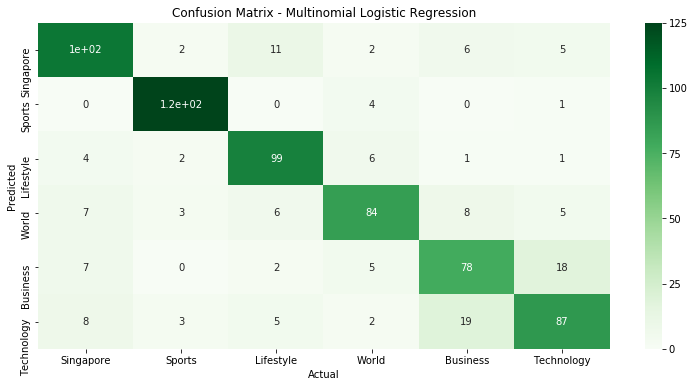

In [8]:
logreg_base_model_confu_matrix = confusion_matrix(tdidf_test_labels, logreg_base_model_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(logreg_base_model_confu_matrix, 
            annot=True,
            xticklabels=category_mapping, 
            yticklabels=category_mapping,
            cmap="Greens")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion Matrix - Multinomial Logistic Regression')
plt.show()

## Hyper Parameter Tuning

In [9]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
print(lr_0.get_params())

Parameters currently in use:

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': 8, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [10]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

print(random_grid)

{'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0], 'multi_class': ['multinomial'], 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'class_weight': ['balanced', None], 'penalty': ['l2']}


In [11]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(tdidf_validation_features, tdidf_validation_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   23.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=8,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight':

In [12]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.7388888888888889


In [13]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(tdidf_validation_features, tdidf_validation_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   10.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_st...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
            

In [14]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.6888888888888889, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.7002801120448179


In [15]:
best_lrc = grid_search.best_estimator_

In [16]:
best_lrc

LogisticRegression(C=0.6888888888888889, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

## Train Optimized Model

In [17]:
best_lrc.fit(tdidf_training_features, tdidf_training_labels)

LogisticRegression(C=0.6888888888888889, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

In [18]:
lrc_pred = best_lrc.predict(tdidf_test_features)

In [19]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(tdidf_training_labels, best_lrc.predict(tdidf_training_features)))

The training accuracy is: 
0.8574652777777778


In [20]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(tdidf_test_labels, lrc_pred))

The test accuracy is: 
0.8055555555555556


In [21]:
best_lrc.fit(tdidf_test_features, tdidf_test_labels)
accuracy_score(tdidf_test_labels, lrc_pred)

0.8055555555555556

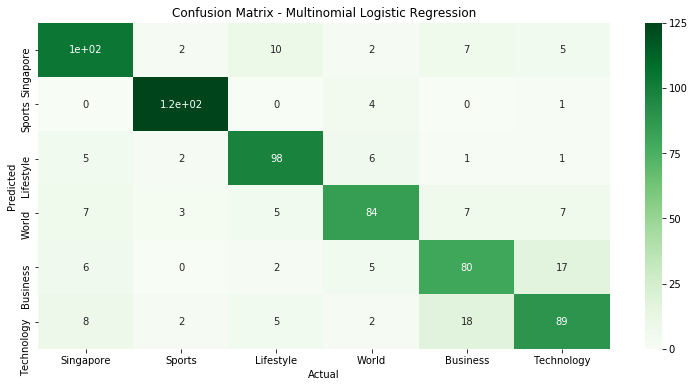

In [22]:
best_lrc_confu_matrix = confusion_matrix(tdidf_test_labels, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(best_lrc_confu_matrix, 
            annot=True,
            xticklabels=category_mapping, 
            yticklabels=category_mapping,
            cmap="Greens")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion Matrix - Multinomial Logistic Regression')
plt.show()